# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:34<00:00, 1.75KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

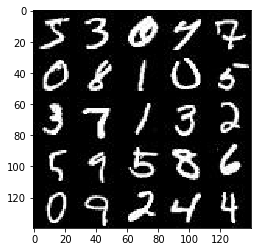

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

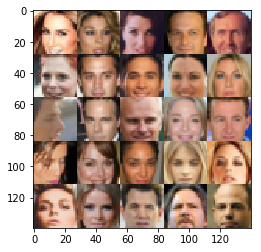

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/gaidys/anaconda/envs/tensorflow_1_0/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name = 'learn_rate')

    return input_real, input_z, learn_rate




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False,  alpha = 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
       
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu2, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True,  alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
   
    with tf.variable_scope('generator', reuse = not is_train):
        
        x1 = tf.reshape(tf.layers.dense(z, 4*4*256), (-1,4,4,256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=3, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='valid')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [52]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                i += 1
                batch_z = np.random.uniform(-1, 1, size = [batch_size, z_dim])
                feed_dict = {input_real: batch_images,
                             input_z: batch_z,
                             learn_rate: learning_rate}
                _ = sess.run(d_opt, feed_dict = feed_dict)
                _ = sess.run(g_opt, feed_dict = feed_dict)
                if i % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    if i % 100 == 0:
                        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2988... Generator Loss: 2.5642
Epoch 1/2... Discriminator Loss: 0.3013... Generator Loss: 1.9184
Epoch 1/2... Discriminator Loss: 0.0596... Generator Loss: 3.4509
Epoch 1/2... Discriminator Loss: 0.0485... Generator Loss: 4.0841
Epoch 1/2... Discriminator Loss: 0.1848... Generator Loss: 2.5193
Epoch 1/2... Discriminator Loss: 0.8180... Generator Loss: 0.8487
Epoch 1/2... Discriminator Loss: 0.1784... Generator Loss: 3.7491
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.7959
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.1865
Epoch 1/2... Discriminator Loss: 0.3994... Generator Loss: 2.1784


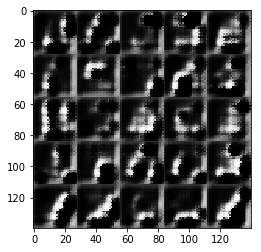

Epoch 1/2... Discriminator Loss: 0.0698... Generator Loss: 3.2955
Epoch 1/2... Discriminator Loss: 0.0585... Generator Loss: 3.9910
Epoch 1/2... Discriminator Loss: 0.0257... Generator Loss: 4.6703
Epoch 1/2... Discriminator Loss: 0.0268... Generator Loss: 4.3984
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 0.8058
Epoch 1/2... Discriminator Loss: 1.8060... Generator Loss: 0.2502
Epoch 1/2... Discriminator Loss: 0.5449... Generator Loss: 2.0124
Epoch 1/2... Discriminator Loss: 0.7453... Generator Loss: 0.9700
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 1.4452
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 1.3603


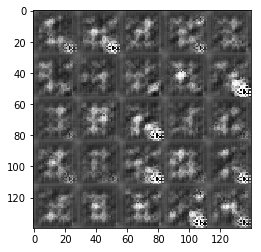

Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 1.8506
Epoch 1/2... Discriminator Loss: 0.9053... Generator Loss: 0.9274
Epoch 1/2... Discriminator Loss: 0.7528... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 0.5349... Generator Loss: 1.3768
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.0749
Epoch 1/2... Discriminator Loss: 0.6235... Generator Loss: 1.3786
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.1164
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 1.8494


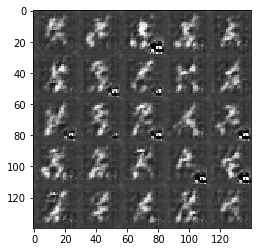

Epoch 1/2... Discriminator Loss: 0.6157... Generator Loss: 1.8697
Epoch 1/2... Discriminator Loss: 0.5320... Generator Loss: 1.7093
Epoch 1/2... Discriminator Loss: 0.5664... Generator Loss: 1.3154
Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 1.4691
Epoch 1/2... Discriminator Loss: 0.8354... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 0.4922... Generator Loss: 1.4310
Epoch 1/2... Discriminator Loss: 0.5954... Generator Loss: 1.4185
Epoch 1/2... Discriminator Loss: 0.4679... Generator Loss: 1.8873
Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 0.3671
Epoch 1/2... Discriminator Loss: 2.0998... Generator Loss: 0.2116


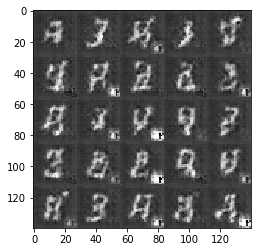

Epoch 1/2... Discriminator Loss: 0.7381... Generator Loss: 1.4202
Epoch 1/2... Discriminator Loss: 0.6729... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 0.7298... Generator Loss: 1.0973
Epoch 1/2... Discriminator Loss: 0.7115... Generator Loss: 1.6313
Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 1.6255
Epoch 1/2... Discriminator Loss: 0.9034... Generator Loss: 0.6748
Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 0.5881
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 1.2212
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 1.7731
Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 1.6836


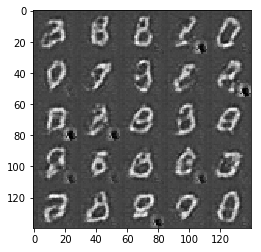

Epoch 1/2... Discriminator Loss: 0.8919... Generator Loss: 1.0371
Epoch 1/2... Discriminator Loss: 0.8983... Generator Loss: 0.7119
Epoch 1/2... Discriminator Loss: 0.7802... Generator Loss: 1.3965
Epoch 1/2... Discriminator Loss: 0.5453... Generator Loss: 1.5304
Epoch 1/2... Discriminator Loss: 1.6962... Generator Loss: 0.3279
Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 1.7138
Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 1.7361
Epoch 1/2... Discriminator Loss: 0.7570... Generator Loss: 0.9770
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 0.9406


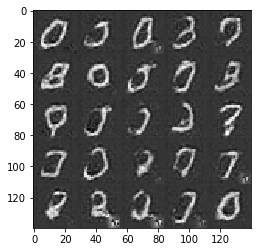

Epoch 1/2... Discriminator Loss: 1.4496... Generator Loss: 0.3714
Epoch 1/2... Discriminator Loss: 0.8520... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 1.8457
Epoch 1/2... Discriminator Loss: 1.0009... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.0207... Generator Loss: 1.1818
Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 0.7615
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 0.8202
Epoch 1/2... Discriminator Loss: 1.5049... Generator Loss: 0.3444
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.4802
Epoch 1/2... Discriminator Loss: 0.7942... Generator Loss: 1.0554


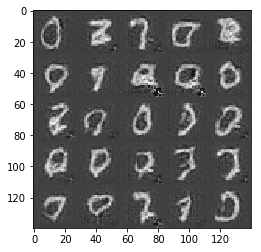

Epoch 1/2... Discriminator Loss: 0.8977... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.3860
Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 0.9044
Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 1.2666
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 1.3938
Epoch 1/2... Discriminator Loss: 0.9617... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.3513
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.9876
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 0.6998


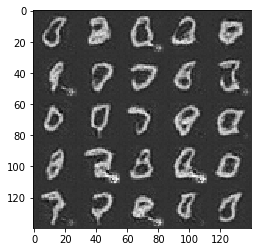

Epoch 1/2... Discriminator Loss: 0.6936... Generator Loss: 1.5244
Epoch 1/2... Discriminator Loss: 0.9169... Generator Loss: 1.0103
Epoch 1/2... Discriminator Loss: 0.8478... Generator Loss: 1.8275
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 0.7309
Epoch 1/2... Discriminator Loss: 0.8986... Generator Loss: 0.9789
Epoch 1/2... Discriminator Loss: 1.6190... Generator Loss: 0.2715
Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 1.1755
Epoch 1/2... Discriminator Loss: 1.0028... Generator Loss: 1.7515
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 0.8266
Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 0.3400


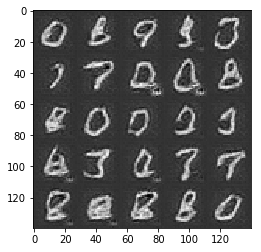

Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 1.1846
Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 1.4613
Epoch 1/2... Discriminator Loss: 0.8287... Generator Loss: 1.1590
Epoch 2/2... Discriminator Loss: 0.7180... Generator Loss: 1.4354
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 1.2668
Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 2.0818
Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 2.0378
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 1.3092
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 1.5261
Epoch 2/2... Discriminator Loss: 0.8119... Generator Loss: 1.5188


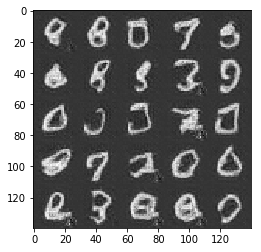

Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.3874
Epoch 2/2... Discriminator Loss: 1.1417... Generator Loss: 0.5830
Epoch 2/2... Discriminator Loss: 0.8117... Generator Loss: 1.4109
Epoch 2/2... Discriminator Loss: 1.6903... Generator Loss: 2.4980
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 1.3517
Epoch 2/2... Discriminator Loss: 0.8045... Generator Loss: 1.0566
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 1.4653
Epoch 2/2... Discriminator Loss: 1.5209... Generator Loss: 0.9358


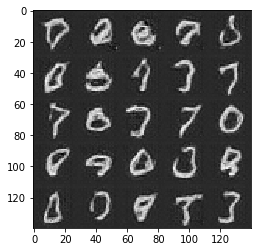

Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 0.9580
Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 1.4848
Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 1.7246
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 0.9612
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 0.6868
Epoch 2/2... Discriminator Loss: 0.7613... Generator Loss: 1.1497
Epoch 2/2... Discriminator Loss: 1.4985... Generator Loss: 0.3318
Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 0.7722
Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 0.4958


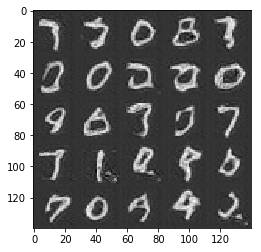

Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 0.6134
Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 1.0641
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 1.8051
Epoch 2/2... Discriminator Loss: 0.8069... Generator Loss: 1.3885
Epoch 2/2... Discriminator Loss: 0.8616... Generator Loss: 1.1091
Epoch 2/2... Discriminator Loss: 0.9113... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 0.6535
Epoch 2/2... Discriminator Loss: 1.1923... Generator Loss: 0.4954
Epoch 2/2... Discriminator Loss: 1.0153... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 1.2055


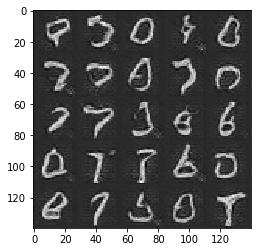

Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 1.6876
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.7989
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 1.6427
Epoch 2/2... Discriminator Loss: 1.1497... Generator Loss: 1.5383
Epoch 2/2... Discriminator Loss: 1.0035... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 1.1718... Generator Loss: 0.5625
Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 0.9018... Generator Loss: 1.4513
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.2775
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 0.7314


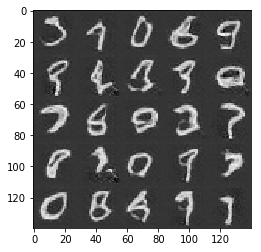

Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 1.2166
Epoch 2/2... Discriminator Loss: 0.9108... Generator Loss: 1.4484
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.2368
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.3798
Epoch 2/2... Discriminator Loss: 0.8498... Generator Loss: 1.7586
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 1.1896
Epoch 2/2... Discriminator Loss: 1.1134... Generator Loss: 0.5549
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 1.1165
Epoch 2/2... Discriminator Loss: 0.9925... Generator Loss: 0.7748
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 1.3773


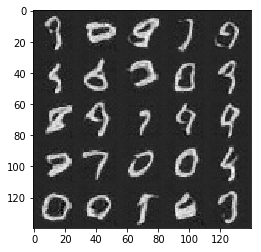

Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 1.1816
Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.5097
Epoch 2/2... Discriminator Loss: 1.0450... Generator Loss: 1.6191
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 0.8311
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 1.4821
Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 1.6525
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 0.6114
Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 1.0380


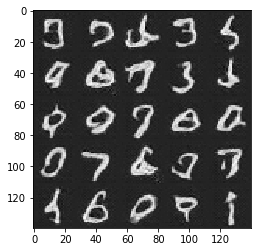

Epoch 2/2... Discriminator Loss: 1.1148... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 0.8836... Generator Loss: 1.5619
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 1.9282
Epoch 2/2... Discriminator Loss: 0.9888... Generator Loss: 1.0854
Epoch 2/2... Discriminator Loss: 1.1503... Generator Loss: 1.8779
Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 1.0958
Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 1.7126
Epoch 2/2... Discriminator Loss: 0.9470... Generator Loss: 1.1212
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.9666


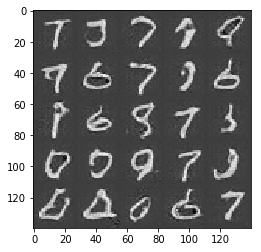

Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 0.9507
Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 1.5057
Epoch 2/2... Discriminator Loss: 1.0106... Generator Loss: 0.8123
Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 1.0750
Epoch 2/2... Discriminator Loss: 0.8686... Generator Loss: 1.3855
Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 1.3665
Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 2.1580
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 0.8130
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 0.8947


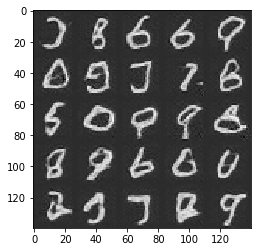

Epoch 2/2... Discriminator Loss: 1.2674... Generator Loss: 0.4896
Epoch 2/2... Discriminator Loss: 1.2730... Generator Loss: 0.5272
Epoch 2/2... Discriminator Loss: 0.9976... Generator Loss: 1.4939
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 0.9773
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 1.1458
Epoch 2/2... Discriminator Loss: 0.9891... Generator Loss: 1.2555
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 1.3518


In [53]:
batch_size = 64
z_dim = 128
learning_rate = .002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2251... Generator Loss: 2.4602
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.5392
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 3.8415
Epoch 1/1... Discriminator Loss: 0.0279... Generator Loss: 4.3368
Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 4.1278
Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 5.1918
Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 5.3977
Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 5.1524
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 4.6319
Epoch 1/1... Discriminator Loss: 0.0148... Generator Loss: 5.4044


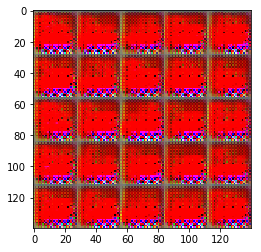

Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 5.5500
Epoch 1/1... Discriminator Loss: 0.0202... Generator Loss: 5.2854
Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 1.2586
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.2733
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.1488


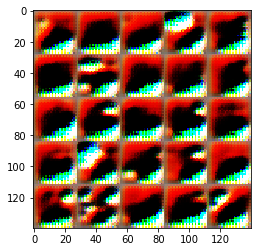

Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.2184
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.6705... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.3973


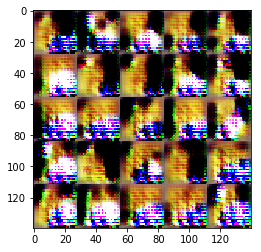

Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.3077
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.7503... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.8659... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8755


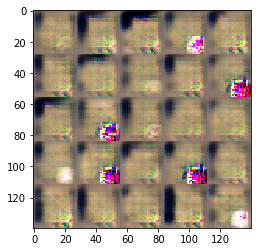

Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.3037
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 1.3069
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.6554
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 2.0487
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 1.2658
Epoch 1/1... Discriminator Loss: 0.3164... Generator Loss: 2.1354
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 2.5195
Epoch 1/1... Discriminator Loss: 0.2671... Generator Loss: 2.3486


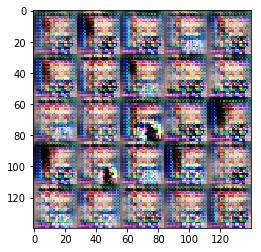

Epoch 1/1... Discriminator Loss: 0.1574... Generator Loss: 2.5172
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 2.7769
Epoch 1/1... Discriminator Loss: 0.0976... Generator Loss: 3.1035
Epoch 1/1... Discriminator Loss: 0.1469... Generator Loss: 2.7482
Epoch 1/1... Discriminator Loss: 0.1228... Generator Loss: 3.1230
Epoch 1/1... Discriminator Loss: 1.9051... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 1.3090
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 1.4836
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.2527


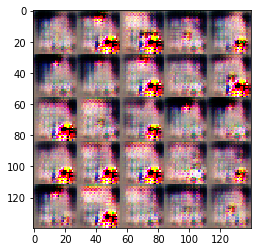

Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 0.4199... Generator Loss: 1.7911
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 1.7028
Epoch 1/1... Discriminator Loss: 0.2237... Generator Loss: 2.3912
Epoch 1/1... Discriminator Loss: 0.1590... Generator Loss: 2.5817
Epoch 1/1... Discriminator Loss: 0.2201... Generator Loss: 2.2330
Epoch 1/1... Discriminator Loss: 0.2558... Generator Loss: 2.8178
Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 1.9392


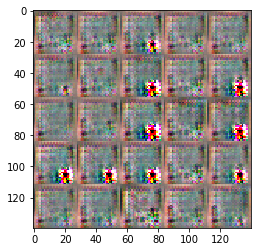

Epoch 1/1... Discriminator Loss: 0.2742... Generator Loss: 1.9963
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 1.4574
Epoch 1/1... Discriminator Loss: 0.4378... Generator Loss: 1.7246
Epoch 1/1... Discriminator Loss: 0.2309... Generator Loss: 2.0817
Epoch 1/1... Discriminator Loss: 1.6867... Generator Loss: 2.9569
Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 1.5781
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 2.2937
Epoch 1/1... Discriminator Loss: 0.3146... Generator Loss: 1.7091
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 1.4131
Epoch 1/1... Discriminator Loss: 2.2901... Generator Loss: 3.8098


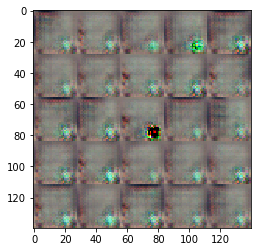

Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 2.1310
Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 1.9841
Epoch 1/1... Discriminator Loss: 0.1544... Generator Loss: 2.6725
Epoch 1/1... Discriminator Loss: 0.0829... Generator Loss: 3.0410
Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 2.9908
Epoch 1/1... Discriminator Loss: 0.0744... Generator Loss: 3.4699
Epoch 1/1... Discriminator Loss: 0.0479... Generator Loss: 4.1239
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 3.6633
Epoch 1/1... Discriminator Loss: 0.0639... Generator Loss: 3.2735
Epoch 1/1... Discriminator Loss: 0.0616... Generator Loss: 3.5073


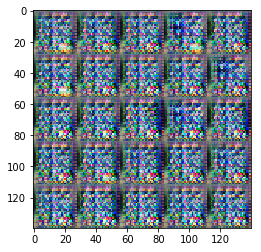

Epoch 1/1... Discriminator Loss: 0.0567... Generator Loss: 3.6771
Epoch 1/1... Discriminator Loss: 0.0565... Generator Loss: 3.6234
Epoch 1/1... Discriminator Loss: 2.7703... Generator Loss: 3.0516
Epoch 1/1... Discriminator Loss: 0.1230... Generator Loss: 2.8374
Epoch 1/1... Discriminator Loss: 0.1187... Generator Loss: 2.6558
Epoch 1/1... Discriminator Loss: 0.1224... Generator Loss: 3.3703
Epoch 1/1... Discriminator Loss: 0.0749... Generator Loss: 3.5436
Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 4.0111
Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 4.4195
Epoch 1/1... Discriminator Loss: 0.0882... Generator Loss: 6.3059


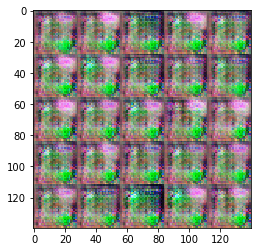

Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.9387


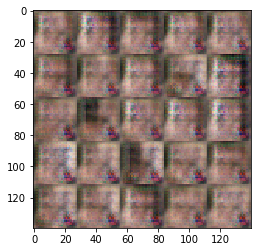

Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.9201


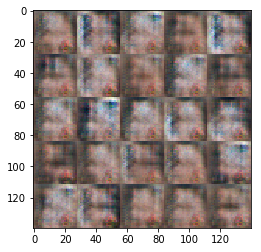

Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7277


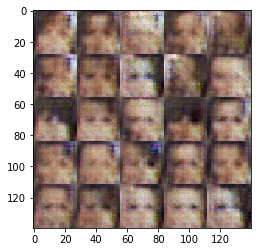

Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.9323


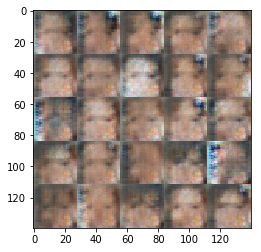

Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8333


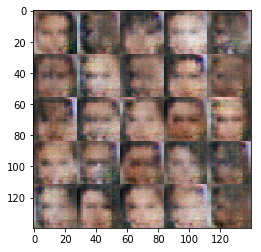

Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7581


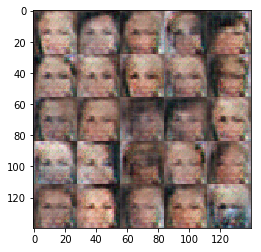

Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.7552


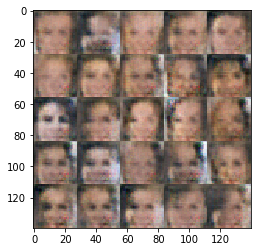

Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6694


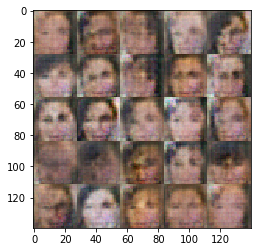

Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7482


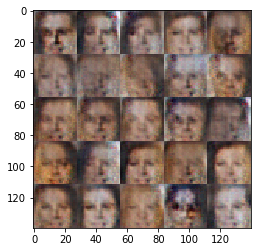

Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8703


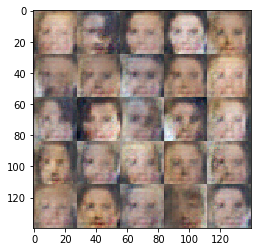

Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7714


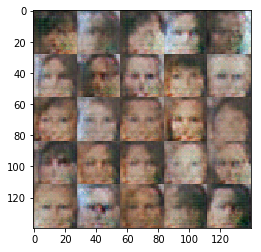

Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.8181


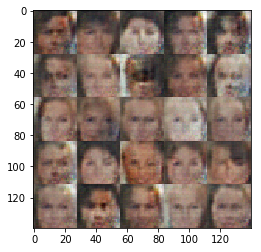

Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 1.0890


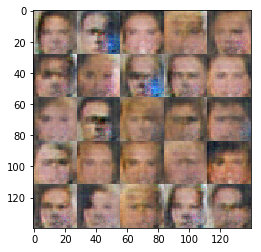

Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8480


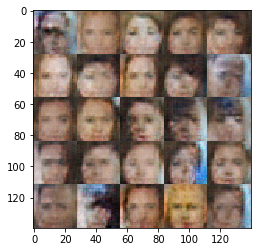

Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5949


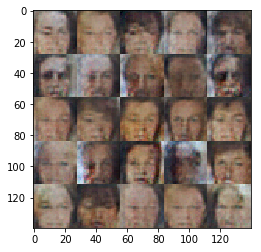

Epoch 1/1... Discriminator Loss: 1.6828... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8175


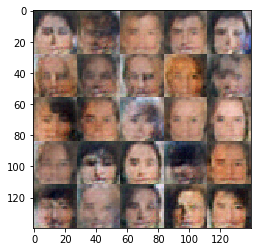

Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.6703


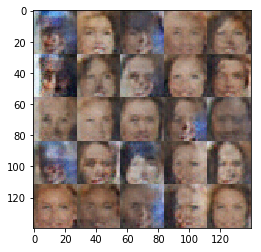

Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6032


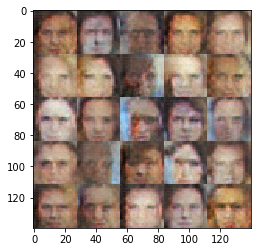

Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7646


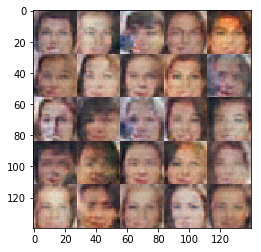

Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7664


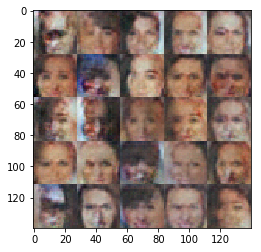

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7182


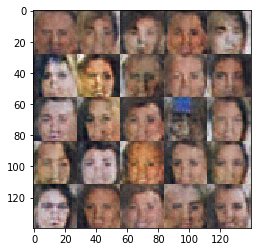

Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.6994


In [54]:
batch_size = 64
z_dim = 128
learning_rate = .002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.